<table><tr><td><img src='GT.png' wspace="20"><td><td><td><td><td><td><td><td><td><td><td><td><td><td><td><td><td><td><td><td><td><td><td><td><td><td><td><td><td><td><img src='sunlab.png' wspace="20"></td></tr></table>


 ##                                                  Ardavan (Ari) Afshar 
 
 ##                                                 aafshar8@gatech.edu

## Using Non-negative Matrix Factorization to Cluster Documents from COVID-19 Open Research Dataset Challenge (CORD-19)


### Dataset Description
In response to the COVID-19 pandemic, the White House and a coalition of leading research groups have prepared the COVID-19 Open Research Dataset (CORD-19). CORD-19 is a resource of over 44,000 scholarly articles, including over 29,000 with full text, about COVID-19, SARS-CoV-2, and related coronaviruses. This freely available dataset is provided to the global research community to apply recent advances in natural language processing and other AI techniques to generate new insights in support of the ongoing fight against this infectious disease. There is a growing urgency for these approaches because of the rapid acceleration in new coronavirus literature, making it difficult for the medical research community to keep up.
  For downloading the data please visit: https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge

### Task
Non-negative matrix factorization (NMF) is a type of dimensionality reduction tetchnique which is used in many applications such as image recognition, topic modeling, and unsupervised phenotyping to name a few.  Here, our aim is to find the cluster of the documents from CORD-19 via NMF. To do that, we first create a document by by term matrix and then apply NMF technique.  We compare the performance and quality of clusters for different input matrices and various NMF approaches ( Frobenius norm, and the generalized Kullback-Leibler divergence).    

### Import the libraries


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import glob
import json
from sklearn.decomposition import NMF
from time import time
import wordcloud
import re
import nltk
from sklearn import metrics
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
path = './CORD-19-research-challenge/2020-03-13'
Documents_json = glob.glob(f'{path}/**/**/*.json', recursive=True)
len(Documents_json)


39606

In [3]:
#For reading the files we used the code from https://www.kaggle.com/maksimeren/covid-19-literature-clustering
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
            # Extend Here
            #
            #
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
first_row = FileReader(Documents_json[0])


In [4]:
#For reading the files we used the code from https://www.kaggle.com/maksimeren/covid-19-literature-clustering
dict_ = {'paper_id': [], 'abstract': [], 'body_text': []}
for idx, entry in enumerate(Documents_json):
    if idx % (len(Documents_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(Documents_json)}')
    content = FileReader(entry)
    dict_['paper_id'].append(content.paper_id)
    dict_['abstract'].append(content.abstract)
    dict_['body_text'].append(content.body_text)
DF_documents = pd.DataFrame(dict_, columns=['paper_id', 'abstract', 'body_text'])


DF_documents.drop_duplicates(['abstract'], inplace=True)
DF_documents.describe(include='all')

Processing index: 0 of 39606
Processing index: 3960 of 39606
Processing index: 7920 of 39606
Processing index: 11880 of 39606
Processing index: 15840 of 39606
Processing index: 19800 of 39606
Processing index: 23760 of 39606
Processing index: 27720 of 39606
Processing index: 31680 of 39606
Processing index: 35640 of 39606
Processing index: 39600 of 39606


,paper_id,abstract,body_text
count,11113,11113,11113
unique,11113,11113,11113
top,9e17fa07642900d9491bf957db97cbe70bc39610,"Over the life course, we are invariably faced ...","data, which should use hierarchical models, ma..."
freq,1,1,1


In order to improve the performance of machine learning algorithms we need to preprocess the dataset. 
The preprocess steps are as follows:
- Remove punctuation from each text
- Convert each text to lower case
- remove stop words
- lemmatizing the words

In [5]:
#Remove punctuation from each text:

DF_documents['body_text'] = DF_documents['body_text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))


In [6]:
#Convert each text to lower case:

def lower_case(input_str):
    input_str = input_str.lower()
    return input_str

DF_documents['body_text'] = DF_documents['body_text'].apply(lambda x: lower_case(x))


In [7]:
#remove stop words
customize_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'fig', 'fig.', 'al.', 'al'
    'di', 'la', 'il', 'del', 'le', 'della', 'dei', 'delle', 'una', 'da',  'dell',  'non', 'si','also'
]

from stop_words import get_stop_words
stop_words = list(get_stop_words('en')) 
stop_words=stop_words+customize_stop_words




DF_documents['body_text'] = DF_documents['body_text'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_words]))


In [8]:
#lemmatizing

nltk.download('wordnet')

import nltk
from nltk.stem import WordNetLemmatizer 

# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()


DF_documents['body_text'] = DF_documents['body_text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(y) for y in x.split()])) # Lemmatize every word.


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ardavanafshar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
DF_documents.head(5)

,paper_id,abstract,body_text
0,8f8eb4f004c2002face0723f2f58cc411954d36e,Bordetella bronchiseptica isolate KM22 has bee...,20kb insert library preparation protocol https...
1,63f7049d200896290b38b38711113054f7ea1b50,,nfectious disease everpresent threat mankind b...
2,4df45b8404d9de0b376a8ae3c282a517df36fe51,The influenza A nucleoprotein (NP) is an attra...,transmission pathogenic avian h5n1 virus poult...
3,e0737ee93afe7b0bf06b1e3f9adf21d541dd10f0,The outbreak of severe acute respiratory syndr...,acute lung injury inflammatory response neutro...
4,3c3572ba243d61e7631725669c8f88347fdbd5bc,The prevalence of feline herpesvirus-1 (FHV-1)...,feline herpesvirus type 1 fhv1 frequent cause ...


In [10]:
text = DF_documents.drop(["paper_id", "abstract"], axis=1)
text_arr = text.stack().tolist()
len(text_arr)
words = []
for ii in range(0,len(text)):
    words.append(str(text.iloc[ii]['body_text']))

In [11]:
all_words = []
for i in range(0,len(DF_documents)):
    all_words.append(str(DF_documents.iloc[i]['body_text']))

In [12]:
print(len(all_words))
print(len(words))

11113
11113


In [40]:
#define functions


def apply_nmf(X,n_components,method_name):
    # Fit the NMF model
    if(method_name=="Frob"):
        print("Fitting the NMF model with Frobinious Norm")
        nmf_output = NMF(n_components=n_components, random_state=1,
                  alpha=.1, l1_ratio=.5).fit(X)
        
    if(method_name=="KL"):
        print("Fitting the NMF model with KL-Divergence Norm")
        nmf_output = NMF(n_components=n_components, random_state=1,
              beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
              l1_ratio=.5).fit(X)
    
    
    return nmf_output


def draw_scactter_plot(X,y):
    
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    # colors
    scatter=plt.scatter(X[:,0], X[:,1], c=y, cmap="Paired", s=50, alpha=1)

    plt.legend(handles=scatter.legend_elements()[0], labels=set(y+1))

    plt.title("t-SNE plot related to Non-negative Matrix Factorization on Covid-19 Articles")



def word_cloud_top_words(model, feature_names, n_top_words):
    number_of_column=2
    num_topics=model.components_.shape[0]
    f, axarr = plt.subplots(int(np.ceil(num_topics/number_of_column)),number_of_column,figsize=(16, 16))
    Dict={}
    for topic_idx, topic in enumerate(model.components_):
        for i in topic.argsort()[:-n_top_words - 1:-1]:
            Dict[feature_names[i]] = topic[i]
        cloud = wordcloud.WordCloud(width=900, height=500,background_color='white').generate_from_frequencies(Dict)
        x=int(np.floor(topic_idx/number_of_column))
        r=topic_idx%number_of_column
        axarr[x,r].imshow(cloud)
        axarr[x,r].axis('off')
        topic_idx=topic_idx+1
        axarr[x,r].set_title("Topic %d " % topic_idx)
        Dict={}


#Silhouette refers to a method of interpretation and validation of consistency within clusters of data.
def calculate_silhouette(X,y):
    silhouette_score = metrics.silhouette_score(X, y, metric='euclidean')
    print ("Silhouette_score: ")
    print (silhouette_score)

## Bag of Words (BoW)
 Bag of Words (BoW) is an approach that counts tthe frequency of a word appears in a document. The word counts allow us to compare how a document is similar to others.  Here we creare a document by term matrix where rows indicate the documents and columns represents the words. Each element in the matrix shows the frequecy of specific word for a particular document. 

In [14]:
vectorizer = CountVectorizer()
X_BoW = vectorizer.fit_transform(all_words)

## NMF with Frobinious Norm on Bag of Words (BoW)


We use non-negative matrix factorization (NMF) to extract topics and cluster the documents from the COVID-19 Open Research Dataset (CORD-19). 
We first introduce the input of NMF algorithm:

- __Document by Term matrix ($X \in \mathbb{R}^{m \times n}):$__ We extract document by term matrix ($\small X \in \mathbb{R}^{m \times n}$) from the COVID-19 Open Research Dataset (CORD-19). Here, $m$ indicates the total number of documents and $n$ represents the total number of words.  $X(i,j)$ indicates the importance (i.e. frequency) of term $j$ for document $i$. 

Next we describe the outputs produced by NMF algorithm:

- __Document-term Matrix ($ U \in \mathbb{R}^{m \times r}$):__  it shows the importance of topics for all documents. Particularly, $U(k,e)$ shows the score of topic $e$ for document $k$. 
- __Topic Definitions ($ V \in \mathbb{R}^{n \times r}$):__  This is a topic-term matrix and defines the topics and shows the participation of different terms codes in all $r$ topics. $V(j,r)$ shows the contribution of term  $j$ on topic $r$.


Below, we introduce the objective function for non-negative matrix factorization problem by minimizing the Frobinious norm:


\begin{aligned}
& \underset{U, V}{\text{minimize}}
& &||A -U V^T||_F^2 \\
& \text{subject to}
 & & U \geq 0; \quad V \geq 0 \quad \quad \quad \quad  \text{Non-negativity Constraint}
\end{aligned}

For more details, you can double check: https://www.cc.gatech.edu/~hpark/papers/nmf_book_chapter.pdf


In [15]:
#settting parameters for NMF and wordclud
n_components=10
n_top_words=20

In [16]:
nmf_Frob_BoW=apply_nmf(X_BoW,n_components,"Frob")

Fitting the NMF model with Frobinious Norm



Topics in NMF model (Frobenius norm):


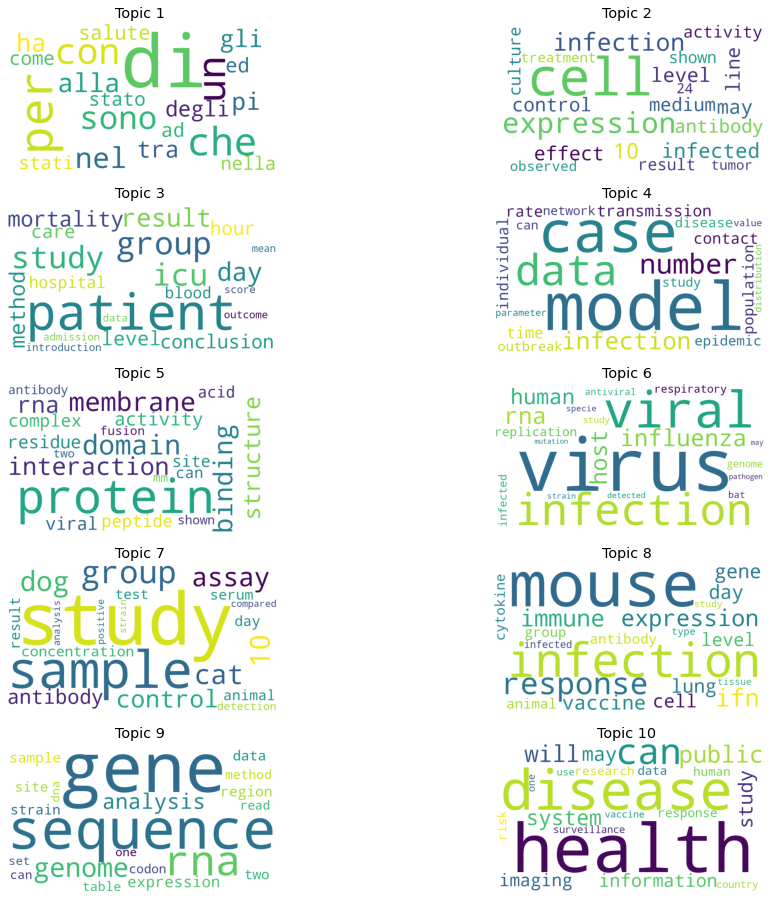

In [17]:

print("\nTopics in NMF model (Frobenius norm):")
count_feature_names = vectorizer.get_feature_names()
word_cloud_top_words(nmf_Frob_BoW, count_feature_names, n_top_words)

In [18]:
document_topic_assignment=nmf_Frob_BoW.fit_transform(X_BoW)
topics=nmf_Frob_BoW.components_

y_pred_BoW=np.argmax(document_topic_assignment, axis=1)

In [19]:
from collections import Counter

Counter(y_pred_BoW).keys() # equals to list(set(words))
Counter(y_pred_BoW).values() # counts the elements' frequency

dict_values([1403, 1239, 1134, 925, 1745, 879, 1331, 1189, 1264, 4])

In [20]:
from sklearn.manifold import TSNE

X_embedded_BoW = TSNE(n_components=2).fit_transform(document_topic_assignment)



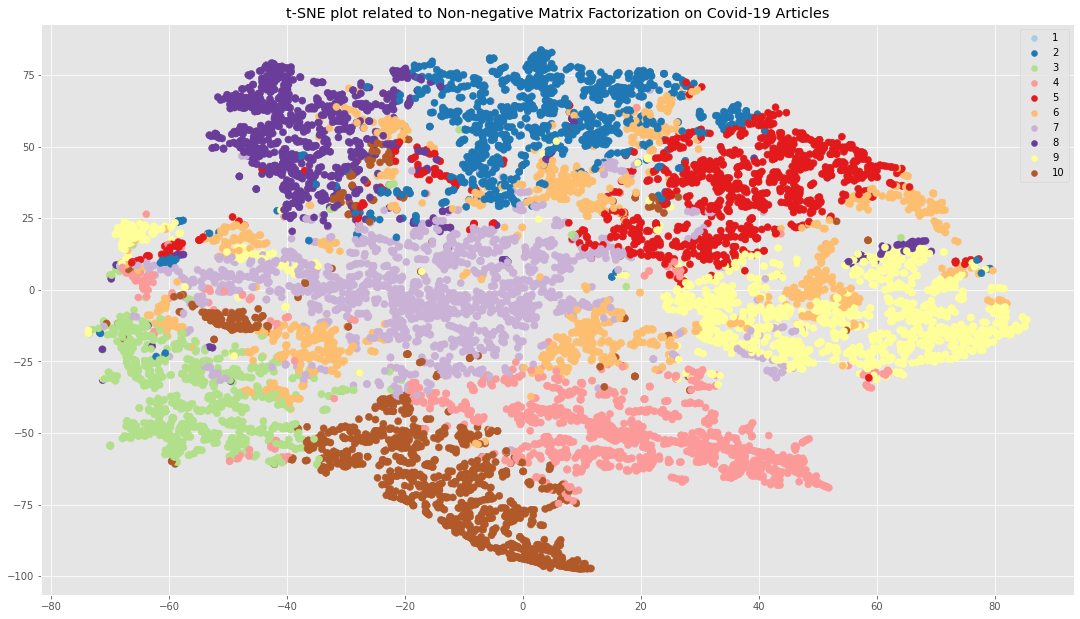

In [41]:
draw_scactter_plot(X_embedded_BoW,y_pred_BoW)

In [22]:
calculate_silhouette(X_embedded_BoW,y_pred_BoW)

Silhouette_score: 
0.16265154


## NMF-KL Divergence on Bag of Words (BoW) Input

NMF using the Frobenius norm considers that the input data are normally
distributed, however, sometimes we face count data.  The Frobenius norm's assumption is not well suited and
may lead to results that misrepresent the data. On the other hand, considering a
Poisson distribution for the input data turns out to be a more realistic assumption, which
implies the use of the KL-Divergence as an objective function. 
For more in formation please visit: http://people.ece.umn.edu/~nikos/a16-papalexakis.pdf

The objective function of non-negative matrix factorization (NMF)  with KL-Divergence has the following form:

\begin{aligned}
D_{KL}(X||U V^T)= \sum_{i,j} X_{ij}  log(\frac{X_{ij}}{(U V^T)_{ij}}) -X_{ij} + (U V^T)_{ij}\\
\end{aligned}

More information is available in: https://www.researchgate.net/publication/221080181_Kullback-Leibler_Divergence_for_Nonnegative_Matrix_Factorization


In [23]:
nmf_KL_BoW=apply_nmf(X_BoW,n_components,"KL")

Fitting the NMF model with KL-Divergence Norm



Topics in NMF model (generalized Kullback-Leibler divergence):


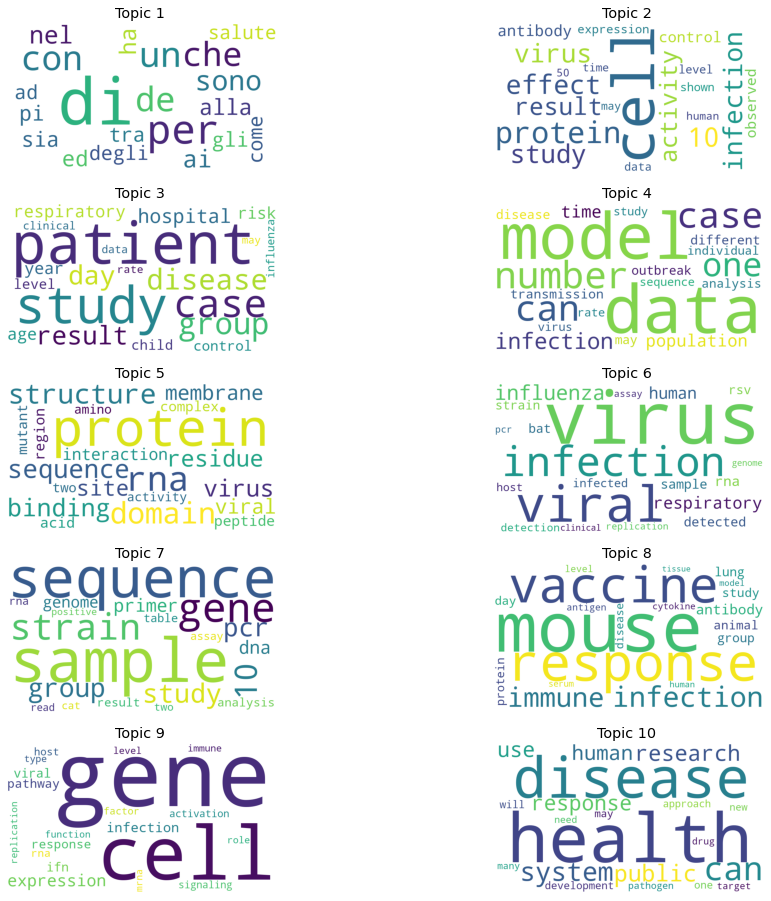

In [25]:
print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
count_KL_feature_names = vectorizer.get_feature_names()
word_cloud_top_words(nmf_KL_BoW, count_KL_feature_names, n_top_words)

In [30]:
document_topic_assignment_KL_count=nmf_KL_BoW.fit_transform(X_BoW)
topics_KL_count=nmf_KL_BoW.components_

y_pred_KL_count=np.argmax(document_topic_assignment_KL_count, axis=1)

In [31]:
from collections import Counter

Counter(y_pred_KL_count).keys() # equals to list(set(words))
Counter(y_pred_KL_count).values() # counts the elements' frequency

dict_values([1374, 809, 1324, 1097, 1355, 1627, 867, 1103, 1544, 13])

In [32]:
from sklearn.manifold import TSNE

X_embedded_count_KL = TSNE(n_components=2).fit_transform(document_topic_assignment_KL_count)



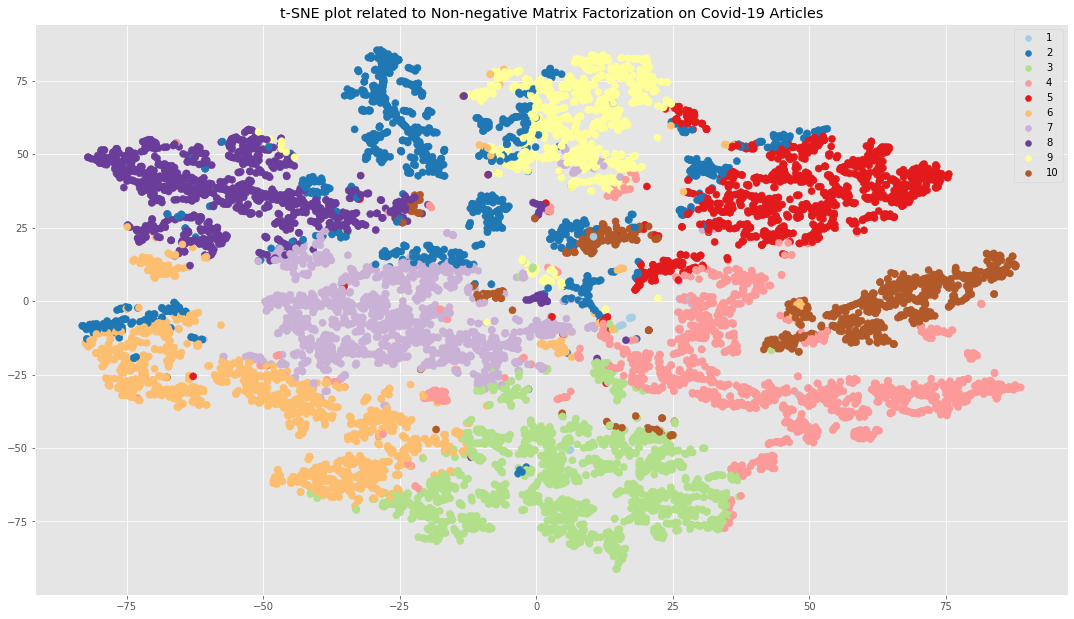

In [36]:
draw_scactter_plot(X_embedded_count_KL,y_pred_KL_count)

In [34]:
calculate_silhouette(X_embedded_count_KL,y_pred_KL_count)

Silhouette_score: 
0.18858735



## TF-IDF Input

 tf–idf or TFIDF, short for term frequency-inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. tf–idf is one of the most popular term-weighting schemes today; 83% of text-based recommender systems in digital libraries use tf–idf. For more inormation please check: https://medium.com/analytics-vidhya/fundamentals-of-bag-of-words-and-tf-idf-9846d301ff22

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Use tf-idf features for NMF.
n_features = 1000

print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')

X_tfidf = tfidf_vectorizer.fit_transform(all_words)


Extracting tf-idf features for NMF...


## NMF with Frobinious Norm on TF-IDF  Input

In [43]:
nmf_Frob_tfidf=apply_nmf(X_tfidf,n_components,"Frob")

Fitting the NMF model with Frobinious Norm



Topics in NMF model (Frobenius norm):


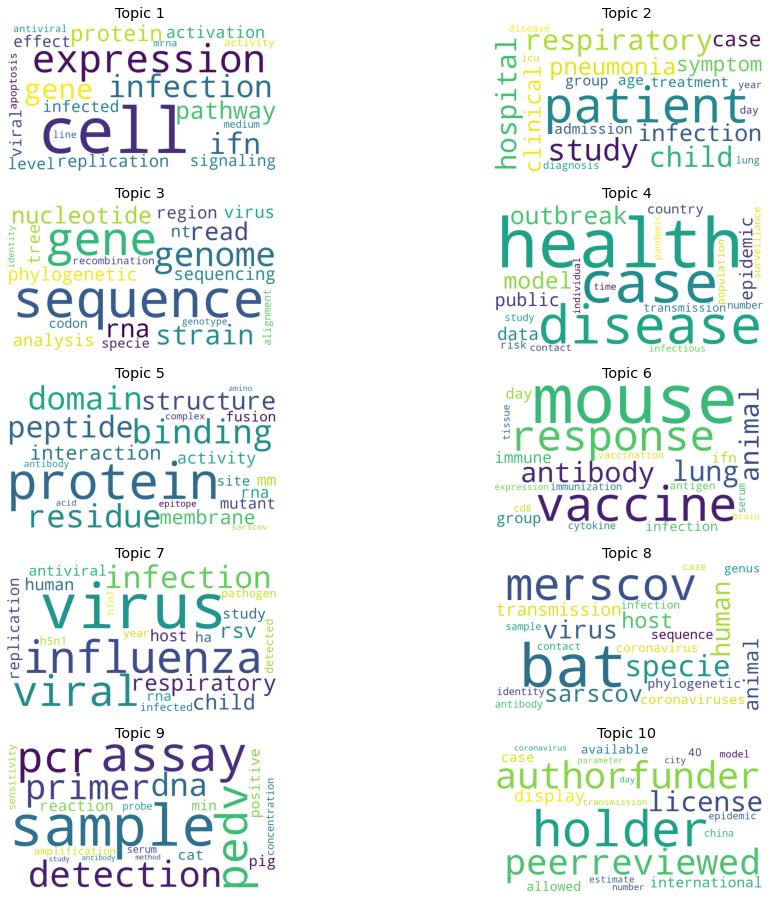

In [44]:
n_top_words=20
print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
word_cloud_top_words(nmf_Frob_tfidf, tfidf_feature_names, n_top_words)

In [45]:
document_topic_assignment=nmf_Frob_tfidf.fit_transform(X_tfidf)
topics=nmf_Frob_tfidf.components_

y_pred=np.argmax(document_topic_assignment, axis=1)

In [46]:


Counter(y_pred).keys() # equals to list(set(words))
Counter(y_pred).values() # counts the elements' frequency

dict_values([1227, 1908, 1068, 1186, 404, 1289, 1615, 1370, 576, 470])

In [47]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(document_topic_assignment)



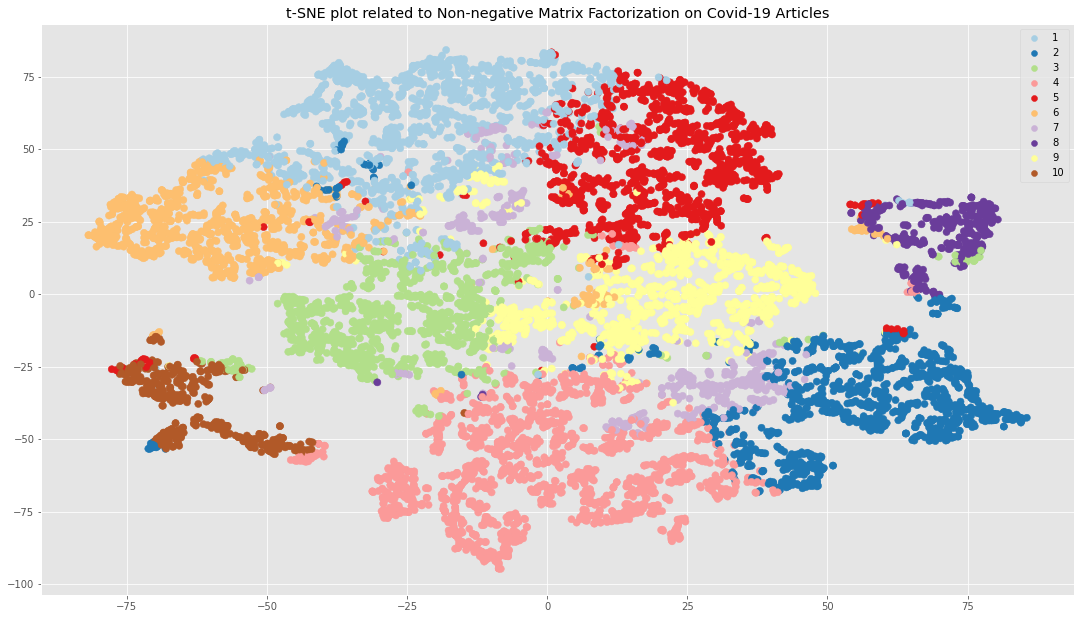

In [48]:
draw_scactter_plot(X_embedded,y_pred)

In [49]:
calculate_silhouette(X_embedded,y_pred)


Silhouette_score: 
0.2901022


## NMF with KL Divergance on TF-IDF  Input

In [50]:
nmf_KL_tfidf=apply_nmf(X_tfidf,n_components,"KL")

Fitting the NMF model with KL-Divergence Norm



Topics in NMF model (generalized Kullback-Leibler divergence):


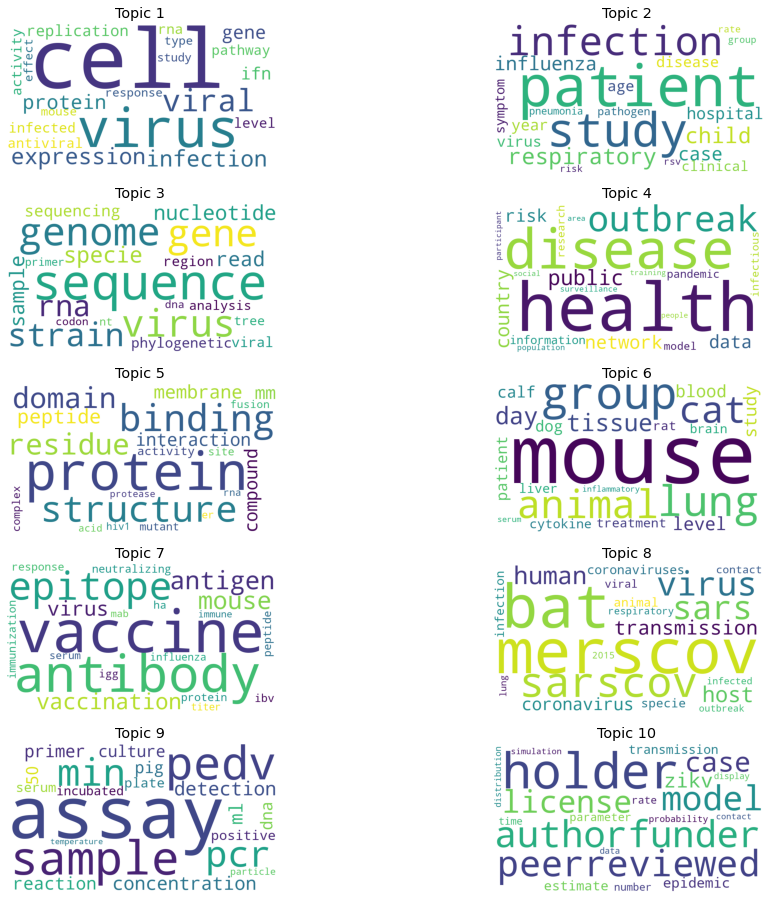

In [51]:
print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
word_cloud_top_words(nmf_KL_tfidf, tfidf_feature_names, n_top_words)

In [52]:
document_topic_assignment_KL=nmf_KL_tfidf.fit_transform(X_tfidf)
topics_KL=nmf_KL_tfidf.components_

y_pred_KL=np.argmax(document_topic_assignment_KL, axis=1)

In [53]:
from collections import Counter

Counter(y_pred).keys() # equals to list(set(words))
Counter(y_pred).values() # counts the elements' frequency

dict_values([1227, 1908, 1068, 1186, 404, 1289, 1615, 1370, 576, 470])

In [54]:
from sklearn.manifold import TSNE

X_embedded_KL = TSNE(n_components=2).fit_transform(document_topic_assignment_KL)



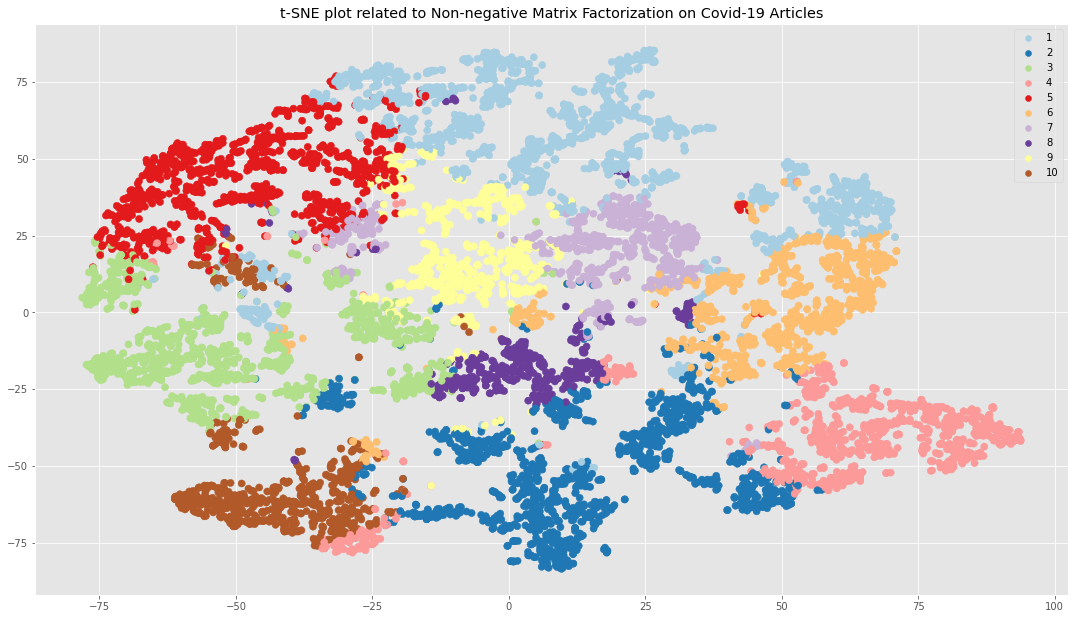

In [55]:
draw_scactter_plot(X_embedded_KL,y_pred_KL)



In [56]:
calculate_silhouette(X_embedded_KL,y_pred_KL)

Silhouette_score: 
0.19536543
